Fin-Bert

In [2]:
import os
import json
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from tqdm import tqdm
import glob

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [3]:
tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

tokenizer_config.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/758 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

In [23]:
def get_sentiment_score(text):
    # calculate single tweet sentiment score
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    
    with torch.no_grad():
        outputs = model(**inputs)
        probabilities = torch.nn.functional.softmax(outputs.logits, dim=-1)
        probabilities = probabilities.cpu().numpy()[0]
    
    # Calculate score and normalize to [0,1]
    sentiment_score = probabilities[0] * 1 + probabilities[1] * -1
    normalized_score = (sentiment_score + 1) / 2
    return normalized_score

def process_daily_file(file_path):
    """Process a single day's file of tweets"""
    try:
        date = os.path.basename(file_path).split('.')[0]  # filename format: YYYY-MM-DD.json
        tweets = []
        with open(file_path, 'r', encoding='utf-8') as f:
            for line in f:
                try:
                    tweet = json.loads(line.strip())
                    tweets.append(tweet['text'])
                except (json.JSONDecodeError, KeyError) as e:
                    continue
        
        # Skip if too few tweets
        if len(tweets) < 3:  # Minimum threshold can be adjusted
            print(f"Skipping {date}: Only {len(tweets)} tweets found")
            return None
        
        # Calculate sentiment scores for all tweets
        sentiment_scores = []
        for tweet in tweets:
            score = get_sentiment_score(tweet)
            sentiment_scores.append(score)
        
        # Calculate daily average sentiment
        daily_score = sum(sentiment_scores) / len(sentiment_scores)
        
        return pd.DataFrame({
            'Date': [date],
            'Sentiment_Score': [daily_score]
        })
        
    except Exception as e:
        print(f"Error processing file {file_path}: {str(e)}")
        return None

In [25]:
def main():
    # Set data directory path
    data_dir = r"D:\STUDY\UCSD\WI25\DSC180B\CAPSTONE-stockreturn\FinBERT\data\AMZN"
    
    # Get all 2022 files
    files = glob.glob(os.path.join(data_dir, '2022*'))
    print(f"Looking for files in: {data_dir}")
    print(f"\nFound {len(files)} files matching '2022*' pattern")
    
    # Process all files
    all_results = []
    for file_path in tqdm(files, desc="Processing files"):
        result_df = process_daily_file(file_path)
        if result_df is not None:
            all_results.append(result_df)
    
    if not all_results:
        raise ValueError("No data was processed successfully")
    final_df = pd.concat(all_results, ignore_index=True)
    final_df = final_df.sort_values('Date')
    
    # Save to CSV in the same directory
    output_path = os.path.join(data_dir, 'amazon_daily_sentiment_2022.csv')
    final_df.to_csv(output_path, index=False)
    print(f"Analysis complete. Results saved to {output_path}")
    print(f"Processed {len(final_df)} days of data")
    
    # Display sample of output
    print("\nFirst few rows of the output:")
    print(final_df.head())

if __name__ == "__main__":
    main()

Looking for files in: D:\STUDY\UCSD\WI25\DSC180B\Bigdata23\tweet\AMZN

Found 251 files matching '2022*' pattern


Processing files:   0%|          | 0/251 [00:00<?, ?it/s]

Processing files: 100%|██████████| 251/251 [02:59<00:00,  1.40it/s]

Analysis complete. Results saved to D:\STUDY\UCSD\WI25\DSC180B\Bigdata23\tweet\AMZN\amazon_daily_sentiment_2022.csv
Processed 251 days of data

First few rows of the output:
         Date  Sentiment_Score
0  2022-01-03         0.483215
1  2022-01-04         0.484946
2  2022-01-05         0.377005
3  2022-01-06         0.527850
4  2022-01-07         0.465256


In [19]:
import seaborn

In [26]:
ss2022 = pd.read_csv("D:/STUDY/UCSD/WI25/DSC180B/CAPSTONE-stockreturn/FinBERT/amazon_daily_sentiment_2022.csv")

<Axes: xlabel='Sentiment_Score', ylabel='Count'>

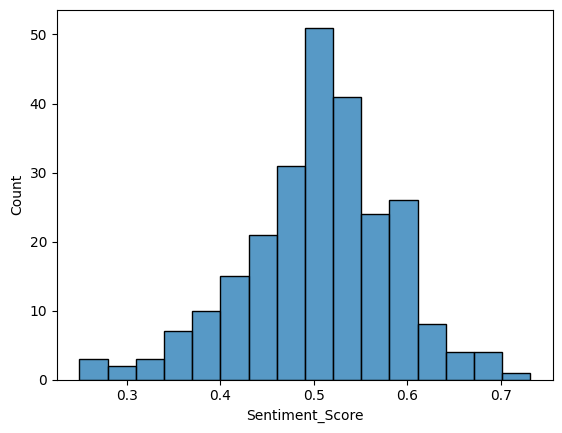

In [27]:
seaborn.histplot(ss2022['Sentiment_Score'])